In [1]:
# importing packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import data

In [2]:
# importing files

labels=pd.read_csv('train_labels.csv')
values=pd.read_csv('train_values.csv')

In [3]:
labels.head()

,patient_id,heart_disease_present
0,0z64un,0
1,ryoo3j,0
2,yt1s1x,1
3,l2xjde,1
4,oyt4ek,0


In [4]:
values.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


In [5]:
values.shape    #there are 14 variables and 180 entries

(180, 14)

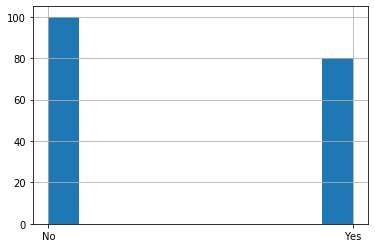

In [6]:
plt.hist(labels['heart_disease_present'])
plt.xticks([0,1],['No','Yes'])
plt.grid()
plt.show()

# Data pre-processing and visualization

In [7]:
labels.set_index('patient_id',inplace=True)
values.set_index('patient_id',inplace=True)

In [8]:
df_train=values.join(labels,on=values.index)

df_train.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
patient_id,,,,,,,,,,,,,,
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


In [9]:
df_train[['fixed_defect','normal','reversible_defect']]=pd.get_dummies(df_train['thal'])

df_train.drop(['thal','reversible_defect'],axis=1,inplace=True)

In [10]:
df_train.shape

(180, 15)

In [11]:
df_train.info()   #all the variables are integer of float number. The patient ID is not a variable

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0z64un to 2nx10r
Data columns (total 15 columns):
slope_of_peak_exercise_st_segment       180 non-null int64
resting_blood_pressure                  180 non-null int64
chest_pain_type                         180 non-null int64
num_major_vessels                       180 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    180 non-null int64
resting_ekg_results                     180 non-null int64
serum_cholesterol_mg_per_dl             180 non-null int64
oldpeak_eq_st_depression                180 non-null float64
sex                                     180 non-null int64
age                                     180 non-null int64
max_heart_rate_achieved                 180 non-null int64
exercise_induced_angina                 180 non-null int64
heart_disease_present                   180 non-null int64
fixed_defect                            180 non-null uint8
normal                                  180 non-null uint8
dtype

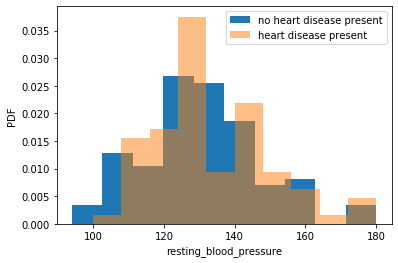

In [26]:
mask0=df_train['heart_disease_present']==0
mask1=df_train['heart_disease_present']==1

plt.hist(df_train.loc[mask0,'resting_blood_pressure'],label='no heart disease present',density=True)
plt.hist(df_train.loc[mask1,'resting_blood_pressure'],alpha=0.5,label='heart disease present',density=True)
plt.xlabel('resting_blood_pressure')
plt.ylabel('PDF')
plt.legend()
plt.show()

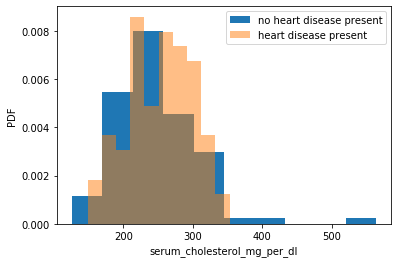

In [27]:
plt.hist(df_train.loc[mask0,'serum_cholesterol_mg_per_dl'],label='no heart disease present',density=True)
plt.hist(df_train.loc[mask1,'serum_cholesterol_mg_per_dl'],alpha=0.5,label='heart disease present',density=True)
plt.xlabel('serum_cholesterol_mg_per_dl')
plt.legend()
plt.ylabel('PDF')
plt.show()

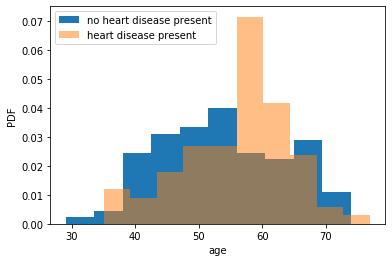

In [28]:
plt.hist(df_train.loc[mask0,'age'],label='no heart disease present',density=True)
plt.hist(df_train.loc[mask1,'age'],alpha=0.5,label='heart disease present',density=True)
plt.xlabel('age')
plt.legend()
plt.ylabel('PDF')
plt.show()

In [38]:
# definition of the array characterizing the training set

X=np.array(df_train.drop('heart_disease_present',axis=1))
y=df_train['heart_disease_present']   # I save in y my training results

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler=StandardScaler()
X_std=scaler.fit_transform(X)
#X_std=X

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.25,random_state=40,stratify=y)

y_train_dumm=pd.get_dummies(y_train)
y_test_dumm=pd.get_dummies(y_test)

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)


# Neural Network

In [42]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout

# Here I build the neural network
ncols=X_train.shape[1]

model=Sequential()

# 1th hidden layer
model.add(Dense(100,input_shape=(ncols,),activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(2,activation='sigmoid'))

# optimizer
#opt=SGD(lr=0.02,momentum=0.5, nesterov=False)

# compile
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# monitor
early_stopping_monitor = EarlyStopping(patience=200,monitor='val_acc')
checkpoint=ModelCheckpoint(filepath='best_model.hdf5',save_weights_only=False,monitor='val_acc',mode='auto',save_best_only=True,verbose=1)


# fit the model
history=model.fit(X_train, y_train_dumm ,epochs=200,validation_data=(X_test,y_test_dumm),callbacks=[early_stopping_monitor,checkpoint],class_weight=class_weights)
print("Loss function: " + model.loss)

Train on 135 samples, validate on 45 samples
Epoch 1/200
135/135 [==============================] - 2s 12ms/step - loss: 0.6920 - acc: 0.5037 - val_loss: 0.6326 - val_acc: 0.6444

Epoch 00001: val_acc improved from -inf to 0.64444, saving model to best_model.hdf5
Epoch 2/200
135/135 [==============================] - 0s 262us/step - loss: 0.6486 - acc: 0.6111 - val_loss: 0.5841 - val_acc: 0.7667

Epoch 00002: val_acc improved from 0.64444 to 0.76667, saving model to best_model.hdf5
Epoch 3/200
135/135 [==============================] - 0s 274us/step - loss: 0.6010 - acc: 0.7296 - val_loss: 0.5430 - val_acc: 0.8333

Epoch 00003: val_acc improved from 0.76667 to 0.83333, saving model to best_model.hdf5
Epoch 4/200
135/135 [==============================] - 0s 300us/step - loss: 0.5574 - acc: 0.7926 - val_loss: 0.5066 - val_acc: 0.8667

Epoch 00004: val_acc improved from 0.83333 to 0.86667, saving model to best_model.hdf5
Epoch 5/200
135/135 [==============================] - 0s 309us/ste

135/135 [==============================] - 0s 382us/step - loss: 0.1695 - acc: 0.9519 - val_loss: 0.4115 - val_acc: 0.8778

Epoch 00043: val_acc did not improve from 0.88889
Epoch 44/200
135/135 [==============================] - 0s 440us/step - loss: 0.1861 - acc: 0.9333 - val_loss: 0.4142 - val_acc: 0.8889

Epoch 00044: val_acc did not improve from 0.88889
Epoch 45/200
135/135 [==============================] - 0s 236us/step - loss: 0.1764 - acc: 0.9444 - val_loss: 0.4188 - val_acc: 0.8889

Epoch 00045: val_acc did not improve from 0.88889
Epoch 46/200
135/135 [==============================] - 0s 244us/step - loss: 0.1837 - acc: 0.9296 - val_loss: 0.4244 - val_acc: 0.8889

Epoch 00046: val_acc did not improve from 0.88889
Epoch 47/200
135/135 [==============================] - 0s 255us/step - loss: 0.1480 - acc: 0.9407 - val_loss: 0.4288 - val_acc: 0.8889

Epoch 00047: val_acc did not improve from 0.88889
Epoch 48/200
135/135 [==============================] - 0s 218us/step - loss: 

135/135 [==============================] - 0s 233us/step - loss: 0.0744 - acc: 0.9741 - val_loss: 0.6553 - val_acc: 0.8000

Epoch 00087: val_acc did not improve from 0.88889
Epoch 88/200
135/135 [==============================] - 0s 246us/step - loss: 0.0813 - acc: 0.9667 - val_loss: 0.6639 - val_acc: 0.8111

Epoch 00088: val_acc did not improve from 0.88889
Epoch 89/200
135/135 [==============================] - 0s 226us/step - loss: 0.0660 - acc: 0.9704 - val_loss: 0.6745 - val_acc: 0.8111

Epoch 00089: val_acc did not improve from 0.88889
Epoch 90/200
135/135 [==============================] - 0s 224us/step - loss: 0.1050 - acc: 0.9556 - val_loss: 0.6803 - val_acc: 0.8000

Epoch 00090: val_acc did not improve from 0.88889
Epoch 91/200
135/135 [==============================] - 0s 254us/step - loss: 0.0671 - acc: 0.9741 - val_loss: 0.6881 - val_acc: 0.8000

Epoch 00091: val_acc did not improve from 0.88889
Epoch 92/200
135/135 [==============================] - 0s 238us/step - loss: 


Epoch 00130: val_acc did not improve from 0.88889
Epoch 131/200
135/135 [==============================] - 0s 317us/step - loss: 0.0329 - acc: 0.9926 - val_loss: 0.8759 - val_acc: 0.7889

Epoch 00131: val_acc did not improve from 0.88889
Epoch 132/200
135/135 [==============================] - 0s 255us/step - loss: 0.0267 - acc: 0.9963 - val_loss: 0.8857 - val_acc: 0.7889

Epoch 00132: val_acc did not improve from 0.88889
Epoch 133/200
135/135 [==============================] - 0s 215us/step - loss: 0.0330 - acc: 0.9926 - val_loss: 0.8923 - val_acc: 0.7778

Epoch 00133: val_acc did not improve from 0.88889
Epoch 134/200
135/135 [==============================] - 0s 241us/step - loss: 0.0257 - acc: 0.9963 - val_loss: 0.8973 - val_acc: 0.7778

Epoch 00134: val_acc did not improve from 0.88889
Epoch 135/200
135/135 [==============================] - 0s 231us/step - loss: 0.0368 - acc: 0.9963 - val_loss: 0.8999 - val_acc: 0.7889

Epoch 00135: val_acc did not improve from 0.88889
Epoch 136

135/135 [==============================] - 0s 265us/step - loss: 0.0194 - acc: 1.0000 - val_loss: 1.0942 - val_acc: 0.7778

Epoch 00174: val_acc did not improve from 0.88889
Epoch 175/200
135/135 [==============================] - 0s 253us/step - loss: 0.0127 - acc: 1.0000 - val_loss: 1.0953 - val_acc: 0.8111

Epoch 00175: val_acc did not improve from 0.88889
Epoch 176/200
135/135 [==============================] - 0s 221us/step - loss: 0.0120 - acc: 1.0000 - val_loss: 1.0974 - val_acc: 0.8111

Epoch 00176: val_acc did not improve from 0.88889
Epoch 177/200
135/135 [==============================] - 0s 226us/step - loss: 0.0300 - acc: 0.9926 - val_loss: 1.1026 - val_acc: 0.7889

Epoch 00177: val_acc did not improve from 0.88889
Epoch 178/200
135/135 [==============================] - 0s 225us/step - loss: 0.0258 - acc: 1.0000 - val_loss: 1.1243 - val_acc: 0.7556

Epoch 00178: val_acc did not improve from 0.88889
Epoch 179/200
135/135 [==============================] - 0s 243us/step - l

In [40]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# Evaluate the performance

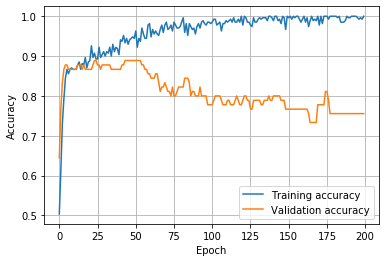

In [43]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Training accuracy','Validation accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               1500      
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 202       
Total params: 11,802
Trainable params: 11,802
Non-trainable params: 0
_________________________________________________________________


In [46]:
my_model = load_model('best_model.hdf5')

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred=np.argmax(my_model.predict(X_test),axis=1)

print(confusion_matrix(y_test,y_pred))

print(classification_report(y_test,y_pred))

[[24  1]
 [ 4 16]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        25
           1       0.94      0.80      0.86        20

    accuracy                           0.89        45
   macro avg       0.90      0.88      0.89        45
weighted avg       0.89      0.89      0.89        45



In [48]:
print('Maximum validation accuracy',round(np.max(history.history['val_acc']),2))

Maximum validation accuracy 0.89
